# Keras - Univariate Time Series Prediction

## Objective of this Notebook

1. Show how to use LSTM for time series prediction with Keras

2. Calculate confidence bands for predictions with LSTMs


In [2]:
# Plotting
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 15, 6

# ignore warnings in this demo notebook
import warnings; warnings.simplefilter('ignore')

from datetime import datetime
import pandas as pd
import numpy as np

# Normalization
from sklearn.preprocessing import MinMaxScaler

# Deep Learing
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from keras import backend as K


from python_code.data_preparation import create_tensors
from python_code.data_preparation import load_series

## Task Description

### Data Parameters

You may have to modify the data preparation file (*00_load_smart_meter_data.R*) when applying this code to your own data. In this example, we just have a look at one series, namely with id `MAC000002`. We have:

- Number of series: 1
- Date range: 2013-10-30 00:00:00 CET to 2014-02-27 23:00:00 CET (121 days)

In [7]:
data_path = 'prepared_data/london_smart_meter/'
file = 'smart_meters_london_cleaned_same_start_with_weather_example.csv'
params = {'column_sort': 'date_time'}

df = load_series(data_path, file, params)
df.index = df.index.tz_localize('UCT').tz_convert('Etc/GMT-1')

### Experiment Parameters

We will fit a model for one day ahead energy prediction by using todays energy consumption. This is a little bit an artificial scnenario, but it is easy to modify this code for other scenarios. We will use 90 days for training (10% for validation) and 30 days for prediction by a rolling window approach.

In [8]:
h_params = {'n_in': 24, 'n_out': 24, 'step_foreward': 24, 'column_value': 'energy'}
date_train =  datetime.strptime('2014-01-27 23:00:00', '%Y-%m-%d %H:%M:%S')

Split the data into train and test set.

In [10]:
df_train = df[df.index <= date_train]
df_test = df[df.index > date_train]

### Prepare Data for LSTM

Let us start with a single series. In the next steps we have to generate the 3 dimensional arrays ([samples, n_in, n_features]) that we need for the LSTM. But before we do this, we have to normalize data on the training set. 

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
# train the scaler on the training data
scaler.fit(df_train[[h_params['column_value']]])
df_train[[h_params['column_value']]] = scaler.transform(df_train[[h_params['column_value']]])
df_test[[h_params['column_value']]] = scaler.transform(df_test[[h_params['column_value']]])

In [12]:
df_train[[h_params['column_value']]].describe()

,energy
count,2160.000000
mean,0.090101
std,0.118516
min,0.000000
25%,0.005903
50%,0.052302
75%,0.140024
max,1.000000


Now, we can calculate the training tensors.

In [13]:
train_X, train_y = create_tensors(df_train.drop('id', axis = 1), h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])

In [14]:
train_X.shape

(89, 24, 9)

### Define & Train LSTM Network

Let us try a simple 3 layer LSTM network.  

In [15]:
def keras_model(rate):
    model = Sequential()
    model.add(Dropout(rate, input_shape=(train_X.shape[1], train_X.shape[2])))
    lstm = LSTM(256, recurrent_dropout=0.3)
    model.add(lstm)
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dense(h_params['n_out']))
    return model

In [16]:
model = keras_model(0.2)
model.compile(loss='mae', optimizer = keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=1, validation_split = .1, verbose=2, shuffle=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 80 samples, validate on 9 samples
Epoch 1/50
 - 4s - loss: 0.5205 - val_loss: 0.2012
Epoch 2/50
 - 3s - loss: 0.3693 - val_loss: 0.1241
Epoch 3/50
 - 3s - loss: 0.2807 - val_loss: 0.1453
Epoch 4/50
 - 3s - loss: 0.2377 - val_loss: 0.1277
Epoch 5/50
 - 3s - loss: 0.2052 - val_loss: 0.1367
Epoch 6/50
 - 3s - loss: 0.1786 - val_loss: 0.0877
Epoch 7/50
 - 3s - loss: 0.1588 - val_loss: 0.0879
Epoch 8/50
 - 3s - loss: 0.1486 - val_loss: 0.0718
Epoch 9/50
 - 3s - loss: 0.1390 - val_loss: 0.0798
Epoch 10/50
 - 3s - loss: 0.1311 - val_loss: 0.0835
Epoch 11/50
 - 2s - loss: 0.1165 - val_loss: 0.0762
Epoch 12/50
 - 3s - loss: 0.1122 - val_loss: 0.0895
Epoch 13/50
 - 2s - loss: 0.1079 - val_loss: 0.0707
Epoch 14/50
 - 3s - loss: 0.1038 - val_loss: 0.0744
Epoch 15/50
 - 3s - loss: 0.0982 - val_loss: 0.0751
Epoch 16/50
 - 3s - loss: 0.0974 - val_l

Summarise the training and validation loss

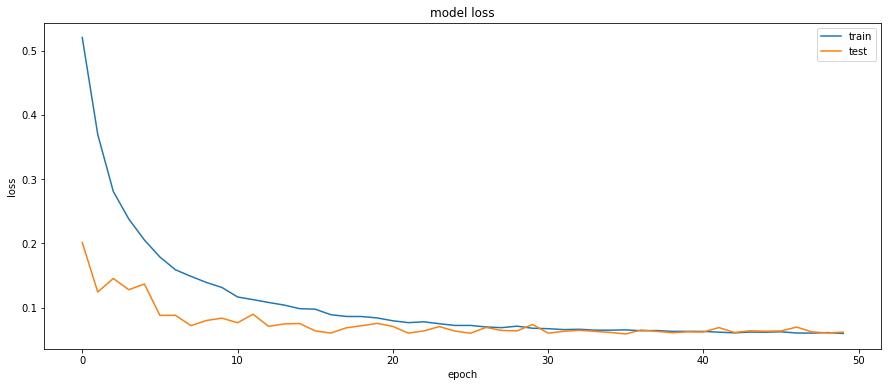

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Perform prediction

In [24]:
test_X, test_y = create_tensors(df_test.drop('id', axis = 1), h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])
prediction = model.predict(test_X)

In [25]:
yHat = scaler.inverse_transform(prediction).reshape(prediction.shape[0] * prediction.shape[1])
y = scaler.inverse_transform(test_y).reshape(prediction.shape[0] * prediction.shape[1])

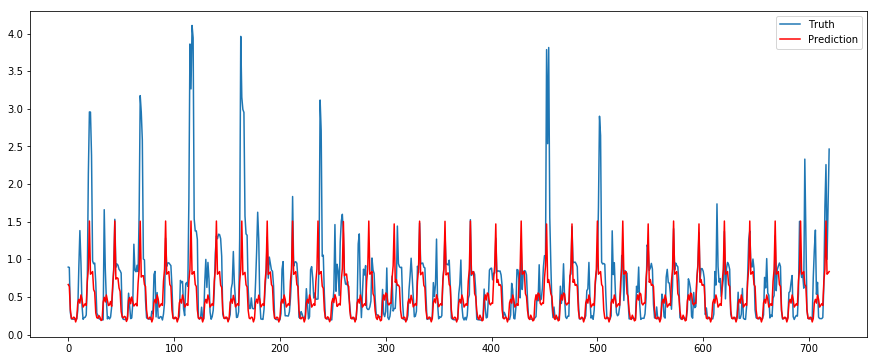

In [26]:
plt.plot(y)
plt.plot(yHat, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.show()

In [27]:
mape = np.mean(np.abs((yHat - y) / y )) * 100
smape = np.mean(np.abs((yHat - y) / (np.abs(y) + np.abs(yHat)) )) * 100
print("MAPE: %.2f SMAPE: %.2f" % (mape, smape))

MAPE: 37.45 SMAPE: 18.47


This can be done better. But let us next try to calculate confidence bands.

## Confidence Bands

In [28]:
def predict_with_uncertainty2(model, test_X, n_iter=100):
    f = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
    all_pred = np.zeros((n_iter,) + (1, 24,))
    for iter in range(n_iter):
        all_pred[iter] = f([test_X, 1])
    ts_std = all_pred.std(axis = 0)
    avg_pred = all_pred.mean(axis=0)
    return all_pred, avg_pred, ts_std

Let us predict the first 10 days with confidence bands.

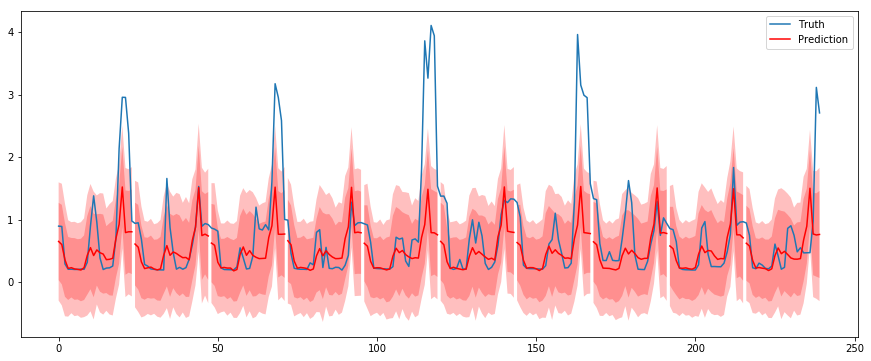

In [30]:
n = 10
plt.plot(y[:(n * 24)])
# n = len(test_X)
for i in range(0, n):
    _, avg_pred, ts_std = predict_with_uncertainty2(model, test_X[i].reshape(1, 24, test_X[i].shape[1]), 100)
    yHat = scaler.inverse_transform(avg_pred).reshape(avg_pred.shape[0] * avg_pred.shape[1])
    YHat_SD = scaler.inverse_transform(ts_std).reshape(ts_std.shape[0] * ts_std.shape[1])
    y = scaler.inverse_transform(test_y).reshape(prediction.shape[0] * prediction.shape[1])
    plt.plot(range(i * 24, (i + 1) * 24), yHat, color='red')
    # plots the uncertainty to the degree of half a standard deviation
    plt.fill_between(range(i * 24, (i + 1) * 24),
                     yHat + 1.96 * YHat_SD, 
                     yHat - 1.96 * YHat_SD, 
                     facecolor='red', alpha=0.25)

    # plots the uncertainty to the degree of a full standard deviation
    plt.fill_between(range(i * 24, (i + 1) * 24),
                     yHat + 3 * YHat_SD, 
                     yHat - 3 * YHat_SD, 
                     facecolor='red', alpha=0.25)
    plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.show()

# Add Time Features

In [31]:
df_train['weekday'] = df_train.index.weekday / 6
df_train['hour'] = df_train.index.hour / 23
df_test['weekday'] = df_test.index.weekday / 6
df_test['hour'] = df_test.index.hour / 23

In [32]:
train_X, train_y = create_tensors(df_train.drop('id', axis = 1), h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])

In [33]:
model = keras_model(0.2)
model.compile(loss='mae', optimizer = keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=1, validation_split = .1, verbose=2, shuffle=True)

Train on 80 samples, validate on 9 samples
Epoch 1/50
 - 3s - loss: 0.4847 - val_loss: 0.1825
Epoch 2/50
 - 3s - loss: 0.3610 - val_loss: 0.1507
Epoch 3/50
 - 3s - loss: 0.2767 - val_loss: 0.1224
Epoch 4/50
 - 3s - loss: 0.2305 - val_loss: 0.1159
Epoch 5/50
 - 3s - loss: 0.2022 - val_loss: 0.1323
Epoch 6/50
 - 3s - loss: 0.1857 - val_loss: 0.1035
Epoch 7/50
 - 3s - loss: 0.1634 - val_loss: 0.1152
Epoch 8/50
 - 3s - loss: 0.1432 - val_loss: 0.0989
Epoch 9/50
 - 3s - loss: 0.1391 - val_loss: 0.0814
Epoch 10/50
 - 3s - loss: 0.1331 - val_loss: 0.0770
Epoch 11/50
 - 3s - loss: 0.1193 - val_loss: 0.0896
Epoch 12/50
 - 3s - loss: 0.1152 - val_loss: 0.0776
Epoch 13/50
 - 3s - loss: 0.1064 - val_loss: 0.0709
Epoch 14/50
 - 3s - loss: 0.0998 - val_loss: 0.0649
Epoch 15/50
 - 3s - loss: 0.1006 - val_loss: 0.0795
Epoch 16/50
 - 3s - loss: 0.0949 - val_loss: 0.0641
Epoch 17/50
 - 3s - loss: 0.0911 - val_loss: 0.0726
Epoch 18/50
 - 3s - loss: 0.0851 - val_loss: 0.0676
Epoch 19/50
 - 3s - loss: 0.08

In [34]:
test_X, test_y = create_tensors(df_test.drop('id', axis = 1), h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])
prediction = model.predict(test_X)

In [35]:
yHat = scaler.inverse_transform(prediction).reshape(prediction.shape[0] * prediction.shape[1])
y = scaler.inverse_transform(test_y).reshape(prediction.shape[0] * prediction.shape[1])

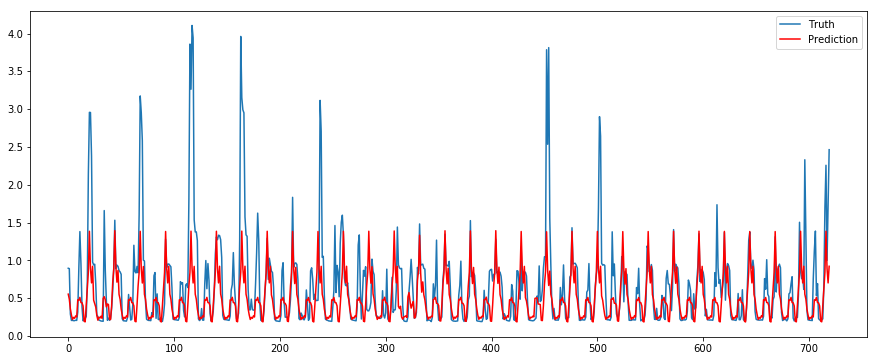

In [36]:
plt.plot(y)
plt.plot(yHat, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.show()

In [37]:
mape = np.mean(np.abs((yHat - y) / y )) * 100
smape = np.mean(np.abs((yHat - y) / (np.abs(y) + np.abs(yHat)) )) * 100
print("MAPE: %.2f SMAPE: %.2f" % (mape, smape))

MAPE: 37.37 SMAPE: 19.27
